# Simple case of data analysis using Pandas and Elasticsearch

When you work with data, one of the first thing you need is to understand those data, compute some metrics, and build a data report. You can use many tools to acheive this goal, but personally, I really like to use Elasticsearch and Kibana to do some "data discovery".

In this notebook, I intend to follow and explain all the basic steps to load an Elasticsearch index in order to explore text data on Kibana.

## Python requirements

- elasticsearch==6.2.0
- nltk==3.2.5
- pandas==0.21.0

## Loading

Data used in this tutorial comes from movie conversation transcripts (http://www.cs.cornell.edu/~cristian//Cornell_Movie-Dialogs_Corpus.html).

For convenience, the data are linked within the same github repository, reformated as more standard csv files (with protected strings and semi-colons as separators).

For our example, we are getting the following information:
- Movie information (title, year, rating) from the *movie_titles_metadata* file
- Transcripts (line identifier, character name, sentence) from the *movie_lines* file
- Conversation information (list of the line identifiers of the conversation) from the *movie_conversations* file

As a first step, we need to rebuild this dataset as one pandas DataFrame where each line will be a sentence (with its associated information).

In [8]:
import pandas as pd

In [9]:
df_lines = pd.read_csv('./movie_transcripts/movie_lines.csv', delimiter=',', escapechar='\\')
df_movies = pd.read_csv('./movie_transcripts/movie_titles_metadata.csv', delimiter=',', escapechar='\\')
df_conversations = pd.read_csv('./movie_transcripts/movie_conversations.csv', delimiter=',', escapechar='\\')

df_conversations.drop(columns=['character1_id', 'character2_id'], inplace=True)
df_movies.drop(columns=['votesnb'], inplace=True)
df_lines.drop(columns=['character_id', 'movie_id'], inplace=True)

from ast import literal_eval
df_conversations['lines'] = df_conversations['lines'].apply(literal_eval)
df_movies['genres'] = df_movies['genres'].str.replace("'", '"')
df_movies['genres'] = df_movies['genres'].apply(literal_eval)

In [10]:
df_conversations

,movie_id,lines
0,m0,"[L194, L195, L196, L197]"
1,m0,"[L198, L199]"
2,m0,"[L200, L201, L202, L203]"
3,m0,"[L204, L205, L206]"
4,m0,"[L207, L208]"
5,m0,"[L271, L272, L273, L274, L275]"
6,m0,"[L276, L277]"
7,m0,"[L280, L281]"
8,m0,"[L363, L364]"
9,m0,"[L365, L366]"


## Merging

Row data are loaded but are not quite in a format that allows us to process them.

The conversations are linked to a list of lines. As we want to reproduce a matrix with one line per sentence, and potentially to keep a conversation identifier, we need to "split" the conversations dataframe.

In [11]:
df_conversations_lines = pd.DataFrame(df_conversations.lines.apply(pd.Series).stack().reset_index())
df_conversations_lines.columns = ['index', 'line_order', 'line_id']
df_conversations.reset_index(inplace=True)
df_conversations_lines

,index,line_order,line_id
0,0,0,L194
1,0,1,L195
2,0,2,L196
3,0,3,L197
4,1,0,L198
5,1,1,L199
6,2,0,L200
7,2,1,L201
8,2,2,L202
9,2,3,L203


We now want to merge all our dataframe to get the information on:
- the movie
- the line transcripts

As here I am not interested in the conversation order in a movie, I won't keep it.

In [12]:
df = pd.merge(df_conversations, df_conversations_lines, how='left', on='index')
df.drop(columns=['index', 'lines'], inplace=True)
df = pd.merge(df, df_movies, how='left', on='movie_id')
df = pd.merge(df, df_lines, how='left', on='line_id')
df.drop(columns=['movie_id', 'line_id'], inplace=True)
df

,line_order,movie_title,year,rating,genres,character_name,text
0,0,10 things i hate about you,1999,6.9,"[comedy, romance]",BIANCA,Can we make this quick? Roxanne Korrine and A...
1,1,10 things i hate about you,1999,6.9,"[comedy, romance]",CAMERON,"Well, I thought we'd start with pronunciation,..."
2,2,10 things i hate about you,1999,6.9,"[comedy, romance]",BIANCA,Not the hacking and gagging and spitting part....
3,3,10 things i hate about you,1999,6.9,"[comedy, romance]",CAMERON,Okay... then how 'bout we try out some French ...
4,0,10 things i hate about you,1999,6.9,"[comedy, romance]",BIANCA,You're asking me out. That's so cute. What's ...
5,1,10 things i hate about you,1999,6.9,"[comedy, romance]",CAMERON,Forget it.
6,0,10 things i hate about you,1999,6.9,"[comedy, romance]",BIANCA,"No, no, it's my fault -- we didn't have a prop..."
7,1,10 things i hate about you,1999,6.9,"[comedy, romance]",CAMERON,Cameron.
8,2,10 things i hate about you,1999,6.9,"[comedy, romance]",BIANCA,"The thing is, Cameron -- I'm at the mercy of a..."
9,3,10 things i hate about you,1999,6.9,"[comedy, romance]",CAMERON,Seems like she could get a date easy enough...


In [13]:
df.shape

(304713, 7)

We now have a complete dataframe with 304.714 sentences and all the information we need about the movies.

## Cleaning

Even from a public source, data are not quite clean. Here pandas considers the columns *year* as string instead of an integer, *text* has unprotected double quotes, and sometime *text* or *character_name* is null.

We will get rid of those issues

In [14]:
df['year'] = df['year'].str.replace(r'/I', '').astype('int32')
df['text'] = df['text'].str.replace('"', '')
df.drop(df[df['text'].isnull()].index, inplace=True)
df.drop(df[df['character_name'].isnull()].index, inplace=True)
df.shape

(304248, 7)

Now that we removed a few lines on our dataframe, we want to add new information.

As we are looking at text data, we might want to count the meaningfull words we have to understand the main topics of our movies dataset.

## Upload

We are going to remove all words in a list of english stopwords so that our analysis in Kibana does not contains them. 

In [8]:
stopwords = [line.rstrip('\n') for line in open('./en_stopwords.txt')]

And to limit the size of our vocabulary, we will use a lemmatizer from nltk library.

In [9]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /Users/ema/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [11]:
import re
from nltk.stem import WordNetLemmatizer

from elasticsearch import Elasticsearch
from elasticsearch import helpers

es = Elasticsearch(timeout=60)
wnl = WordNetLemmatizer()

if es.indices.exists("data_tutorial"):
    es.indices.delete(index="data_tutorial")

settings = {
    "mappings": {
        "doc": {
            "properties": {
                "text": {
                    "type": "text"
                },
                "words": {
                    "type": "keyword"
                },
                "character": {
                    "type": "keyword"
                },
                "year": {
                    "type": "long"
                },
                "movie": {
                    "type": "keyword"
                },
                "genres": {
                    "type": "keyword"
                },
                "rating": {
                    "type": "double"
                }
            }
        }
    }
}
# create index
es.indices.create(index="data_tutorial", ignore=400, body=settings)


s = ""
actions = []
for i, row in df.iterrows():
    words = re.findall("(\w+)", str(row['text']))
    words = [wnl.lemmatize(w.lower(), 'v') for w in words if w.lower() not in stopwords and len(w) > 1 and not w.isdigit()]
    
    actions.append({
        "_index": "data_tutorial",
        "_type": "doc",
        "_source": {
            "text" : str(row['text']).replace('\n', '\\n'), 
            "words": words, 
            "movie": row['movie_title'], 
            "year": row['year'],
            "rating": row['rating'], 
            "character": row['character_name'],
            "genres": row['genres']
        }})

helpers.bulk(es, actions)
        

(304248, [])

For information, here I am using Elasticsearch and Kibana 6.3. The doc_type in the mapping will be progressively removed in the next versions, so it might need some adaptation.

## Visulization in Kibana

Tag cloud on lemmas:

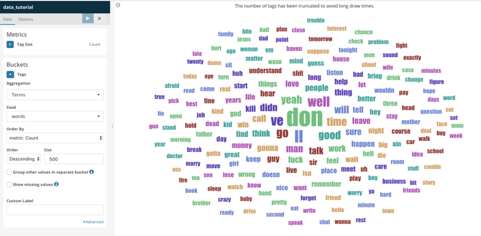

Heatmap on movie year vs genres:

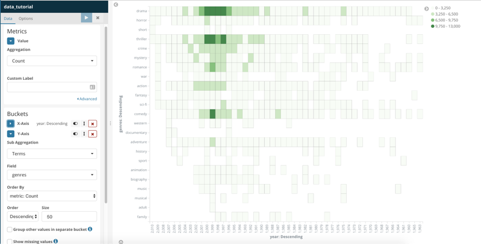

Example of dashboard:

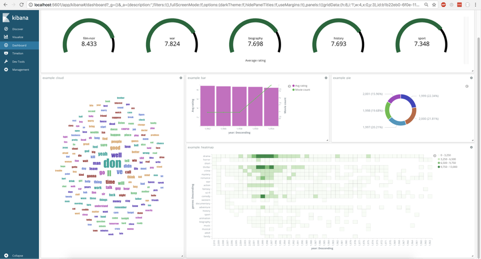